# Diagnostic Demand Visualisation by LSOA

This notebook visualises the estimated CT demand per LSOA across the South West region.  
We will:

1. Load spatial CT demand outputs from `estimate_mri_demand_from_gpkg()`
2. Visualise demand as a choropleth map
3. Prepare a base for overlaying LSOA-to-LSOA travel data for network or gravity-style modelling


In [1]:
# ------------------------------------------------------------------
# Step 0 – Imports, File Paths, and Script Path Setup (MRI)
# ------------------------------------------------------------------
import os
import sys
import pandas as pd
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt

# Add the 'scripts' folder to Python import path
script_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/scripts"
if script_dir not in sys.path:
    sys.path.append(script_dir)

# File locations
data_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/raw"
modality_dir = os.path.join(data_dir, "modality_modelling")

gpkg_path = os.path.join(data_dir, "LSOA_5-year_segment_master.gpkg")
travel_csv_path = os.path.join(data_dir, "LSOA_to_LSOA_complete.csv")
modality_counts_path = os.path.join(data_dir, "modality_procedure_counts_by_age_band_2024.csv")

# Updated capability-based input paths
cdc_path = os.path.join(data_dir, "health_infra/NHS_SW_ Community_Diagnostic_Centres_enriched.csv")
acute_path = os.path.join(modality_dir, "NHS_SW_Acute_Hospitals_Capability.csv")

# Confirm file existence
for path in [gpkg_path, travel_csv_path, modality_counts_path, cdc_path, acute_path]:
    assert os.path.exists(path), f"Missing file: {path}"

# Utility function to check columns
def print_columns(filepath, is_geopkg=False):
    print(f"\nColumns in: {os.path.basename(filepath)}")
    try:
        if is_geopkg:
            df = gpd.read_file(filepath)
        else:
            df = pd.read_csv(filepath, nrows=5)  # Just preview first few rows for speed
        print(df.columns.tolist())
    except Exception as e:
        print(f"Could not read: {e}")

# Run checks
print_columns(gpkg_path, is_geopkg=True)
print_columns(travel_csv_path)
print_columns(modality_counts_path)
print_columns(cdc_path)
print_columns(acute_path)



Columns in: LSOA_5-year_segment_master.gpkg
['ICB23NM', 'ladnm', 'ladcd', 'msoa21nm', 'msoa21cd', 'lsoa21nmw', 'lsoa21cd', 'total_population', 'age_0_4', 'age_5_9', 'age_10_14', 'age_15_19', 'age_20_24', 'age_25_29', 'age_30_34', 'age_35_39', 'age_40_44', 'age_45_49', 'age_50_54', 'age_55_59', 'age_60_64', 'age_65_69', 'age_70_74', 'age_75_79', 'age_80_84', 'age_85_plus', 'lat', 'long', 'bng_e', 'bng_n', 'lsoa21nm', 'geometry']

Columns in: LSOA_to_LSOA_complete.csv
['origin_name', 'destination_name', 'travel_time_car', 'travel_time_pt_peak', 'travel_time_pt_nonpeak']

Columns in: modality_procedure_counts_by_age_band_2024.csv
['age_band', 'CT_Cancer Pathway', 'CT_Non-Cancer Pathway', 'CT_Total', 'Endoscopy_Cancer Pathway', 'Endoscopy_Non-Cancer Pathway', 'Endoscopy_Total', 'MRI_Cancer Pathway', 'MRI_Non-Cancer Pathway', 'MRI_Total']

Columns in: NHS_SW_ Community_Diagnostic_Centres_enriched.csv
['Code', 'Name', 'Address 1', 'Address 2', 'Address 3', 'Address 4', 'Address 5', 'Postcod

In [2]:
# ------------------------------------------------------------------
# Step 1 – Load MRI Demand Estimates
# ------------------------------------------------------------------
from estimate_mri_demand_from_gpkg import estimate_mri_demand_from_gpkg

mri_demand_df = estimate_mri_demand_from_gpkg()
print("Loaded MRI demand per LSOA:")
display(mri_demand_df.head())


Loaded MRI demand per LSOA:


,lsoa21cd,mri_total_demand,mri_age_0_4,mri_age_5_9,mri_age_10_14,mri_age_15_19,mri_age_20_24,mri_age_25_29,mri_age_30_34,mri_age_35_39,mri_age_40_44,mri_age_45_49,mri_age_50_54,mri_age_55_59,mri_age_60_64,mri_age_65_69,mri_age_70_74,mri_age_75_79,mri_age_80_84,mri_age_85_plus
0,E01020484,86.103249,0.420034,0.674371,1.473437,2.436694,1.792333,1.740134,3.326240,4.254983,3.977259,5.002384,7.013377,8.454571,10.699525,9.221666,8.839622,8.570267,5.471246,2.735108
1,E01020481,89.386028,0.380968,0.312741,0.796399,0.878502,1.503412,1.817659,2.507116,2.587459,3.219774,3.394224,4.457436,8.756494,13.633457,11.616180,12.549362,11.282391,5.295202,4.397253
2,E01020482,94.250505,0.673916,0.742855,1.453478,1.331814,1.907958,2.939113,4.917585,4.657878,5.555507,5.240564,5.964720,9.587337,12.770236,9.044779,10.260539,10.089440,4.323923,2.788862
3,E01020479,75.457109,0.322320,0.312741,0.637120,1.303413,0.953979,1.392031,1.735368,1.609887,1.830743,2.977554,3.277375,5.737269,6.644593,9.221666,8.287388,12.801564,8.207302,8.204797
4,E01020478,69.763845,0.361387,0.430018,1.015556,1.643397,1.358809,1.237361,1.928186,2.817443,3.535548,3.275426,5.309631,7.775060,7.852084,7.803082,7.340369,8.895424,4.235468,2.949595


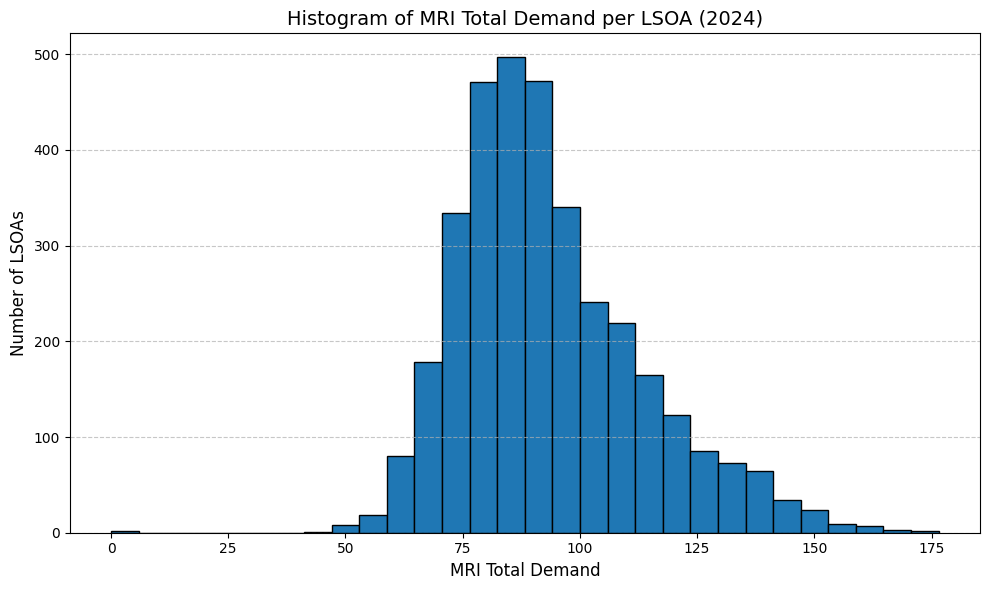

In [4]:
# ------------------------------------------------------------------
# Step 1a – Histogram of MRI Total Demand per LSOA
# ------------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.hist(mri_demand_df["mri_total_demand"], bins=30, edgecolor='black')

plt.title("Histogram of MRI Total Demand per LSOA (2024)", fontsize=14)
plt.xlabel("MRI Total Demand", fontsize=12)
plt.ylabel("Number of LSOAs", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


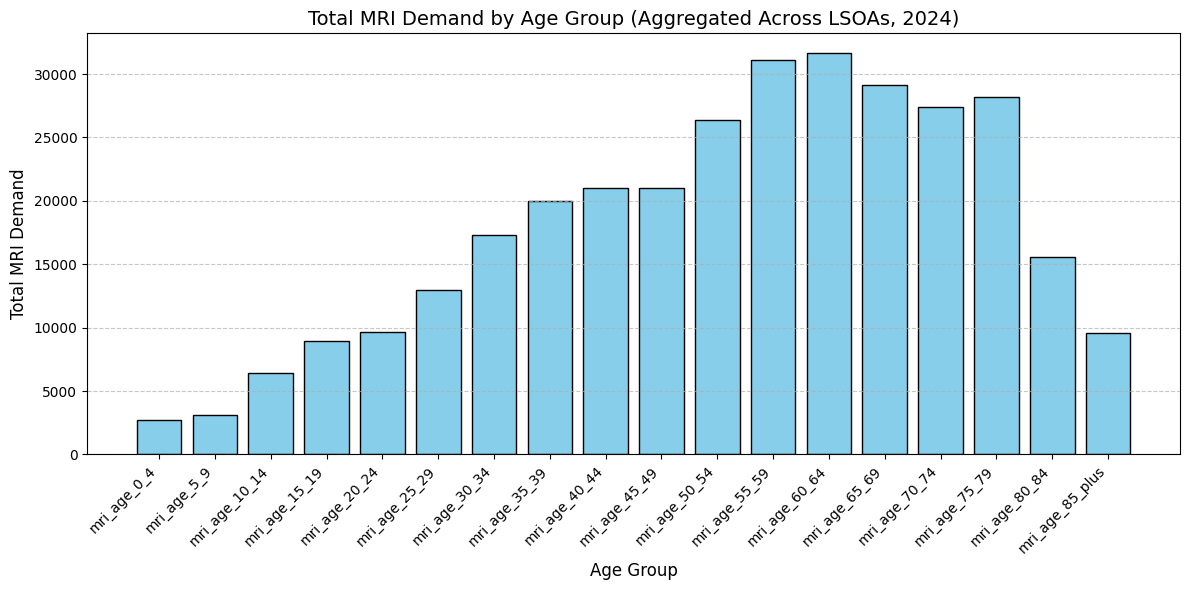

In [5]:
# ------------------------------------------------------------------
# Step 1b – Histogram of MRI Demand by Age Group (Aggregated Across LSOAs)
# ------------------------------------------------------------------

# Define age group columns (ensure these match your actual DataFrame)
age_cols = [
    "mri_age_0_4", "mri_age_5_9", "mri_age_10_14", "mri_age_15_19", "mri_age_20_24",
    "mri_age_25_29", "mri_age_30_34", "mri_age_35_39", "mri_age_40_44", "mri_age_45_49",
    "mri_age_50_54", "mri_age_55_59", "mri_age_60_64", "mri_age_65_69", "mri_age_70_74",
    "mri_age_75_79", "mri_age_80_84", "mri_age_85_plus"
]

# Sum across all LSOAs for each age group
age_totals = mri_demand_df[age_cols].sum()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(age_totals.index, age_totals.values, color='skyblue', edgecolor='black')

plt.title("Total MRI Demand by Age Group (Aggregated Across LSOAs, 2024)", fontsize=14)
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Total MRI Demand", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


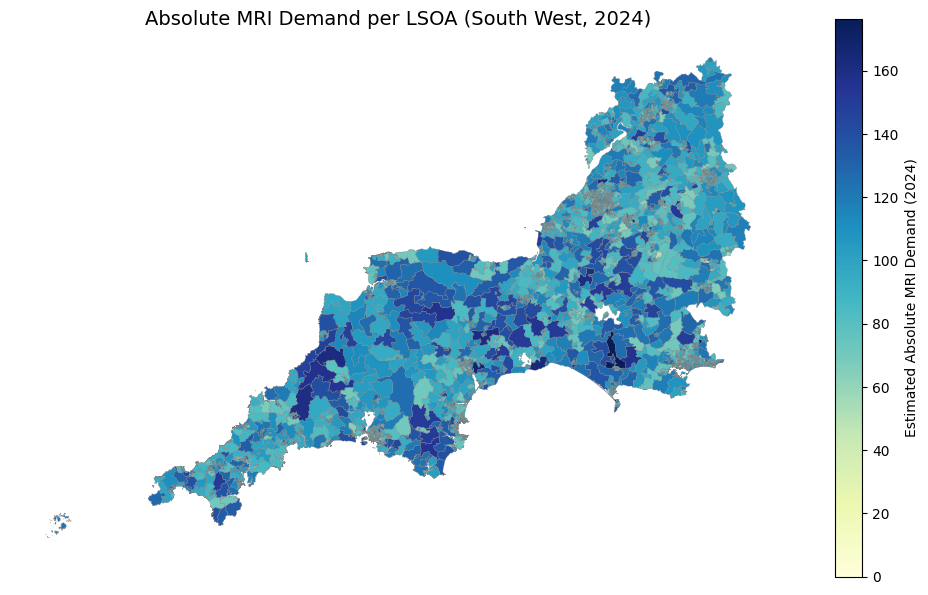

In [6]:
# ------------------------------------------------------------------
# Step 2 – Choropleth of Absolute MRI Demand per LSOA (2024, 300 DPI)
# ------------------------------------------------------------------

# Reload GPKG with geometry
gdf_geom = gpd.read_file(gpkg_path)[["lsoa21cd", "geometry"]]

# Merge with MRI demand
gdf_mri = gdf_geom.merge(
    mri_demand_df[["lsoa21cd", "mri_total_demand"]],
    on="lsoa21cd",
    how="left"
)

# Plot choropleth
fig, ax = plt.subplots(figsize=(10, 6))  # shorter height for cleaner layout
gdf_mri.plot(
    column="mri_total_demand",
    cmap="YlGnBu",
    linewidth=0.2,
    edgecolor="grey",
    legend=True,
    legend_kwds={'label': "Estimated Absolute MRI Demand (2024)"},
    ax=ax
)

ax.set_title("Absolute MRI Demand per LSOA (South West, 2024)", fontsize=14)
ax.axis("off")
plt.tight_layout()

# Save at high resolution (optional)
output_path = "mri_demand_absolute_choropleth_2024.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()


In [7]:
# ------------------------------------------------------------------
# Step 3 – Compute Nearest Diagnostic Site (CDC or Acute) by Car Travel Time
# ------------------------------------------------------------------

# Load cleaned LSOA-to-LSOA travel matrix
travel_df = pd.read_csv(travel_csv_path)
travel_df = travel_df.rename(columns={
    "origin_name": "origin_lsoa",
    "destination_name": "dest_lsoa",
    "travel_time_car": "car_travel_minutes"
})

# Ensure correct data types
travel_df["car_travel_minutes"] = pd.to_numeric(travel_df["car_travel_minutes"], errors="coerce")
travel_df["origin_lsoa"] = travel_df["origin_lsoa"].astype(str)
travel_df["dest_lsoa"] = travel_df["dest_lsoa"].astype(str)

# Load and tag Community Diagnostic Centres (CDC) and Acute sites
cdc_df = pd.read_csv(cdc_path)
acute_df = pd.read_csv(acute_path)

facilities_df = pd.concat([
    cdc_df[["Name", "lsoa21cd"]].assign(facility_type="CDC"),
    acute_df[["Name", "lsoa21cd"]].assign(facility_type="Acute")
], ignore_index=True).dropna(subset=["lsoa21cd"]).drop_duplicates()

facilities_df["lsoa21cd"] = facilities_df["lsoa21cd"].astype(str)

# Join travel matrix with facility locations
nearest_candidates = travel_df.merge(
    facilities_df,
    left_on="dest_lsoa",
    right_on="lsoa21cd",
    how="inner"
).drop(columns=["lsoa21cd"])  # remove duplicate column after merge

# Identify the nearest site by shortest travel time for each origin LSOA
nearest_sites = (
    nearest_candidates
    .sort_values("car_travel_minutes")
    .groupby("origin_lsoa")
    .first()
    .reset_index()
    .rename(columns={
        "origin_lsoa": "lsoa21cd",
        "Name": "nearest_site",
        "facility_type": "nearest_type",
        "car_travel_minutes": "travel_to_nearest_mins"
    })[[
        "lsoa21cd",
        "nearest_site",
        "nearest_type",
        "travel_to_nearest_mins"
    ]]
)

# Merge nearest site info with MRI demand GeoDataFrame
gdf_mri["lsoa21cd"] = gdf_mri["lsoa21cd"].astype(str)
nearest_sites["lsoa21cd"] = nearest_sites["lsoa21cd"].astype(str)

gdf_mri = gdf_mri.merge(nearest_sites, on="lsoa21cd", how="left")

# Tag if the LSOA contains a facility
facility_lsoas = set(facilities_df["lsoa21cd"])
gdf_mri["facility_onsite"] = gdf_mri["lsoa21cd"].isin(facility_lsoas)

# Preview result
gdf_mri[[
    "lsoa21cd",
    "mri_total_demand",
    "nearest_site",
    "nearest_type",
    "travel_to_nearest_mins",
    "facility_onsite"
]].head()


,lsoa21cd,mri_total_demand,nearest_site,nearest_type,travel_to_nearest_mins,facility_onsite
0,E01020484,86.103249,Dorset Health Village Poole Beales CDC,CDC,37.262783,False
1,E01020481,89.386028,Dorset Health Village Poole Beales CDC,CDC,40.298602,False
2,E01020482,94.250505,Dorset Health Village Poole Beales CDC,CDC,37.925839,False
3,E01020479,75.457109,Dorset Health Village Poole Beales CDC,CDC,38.583952,False
4,E01020478,69.763845,Dorset Health Village Poole Beales CDC,CDC,36.993783,False


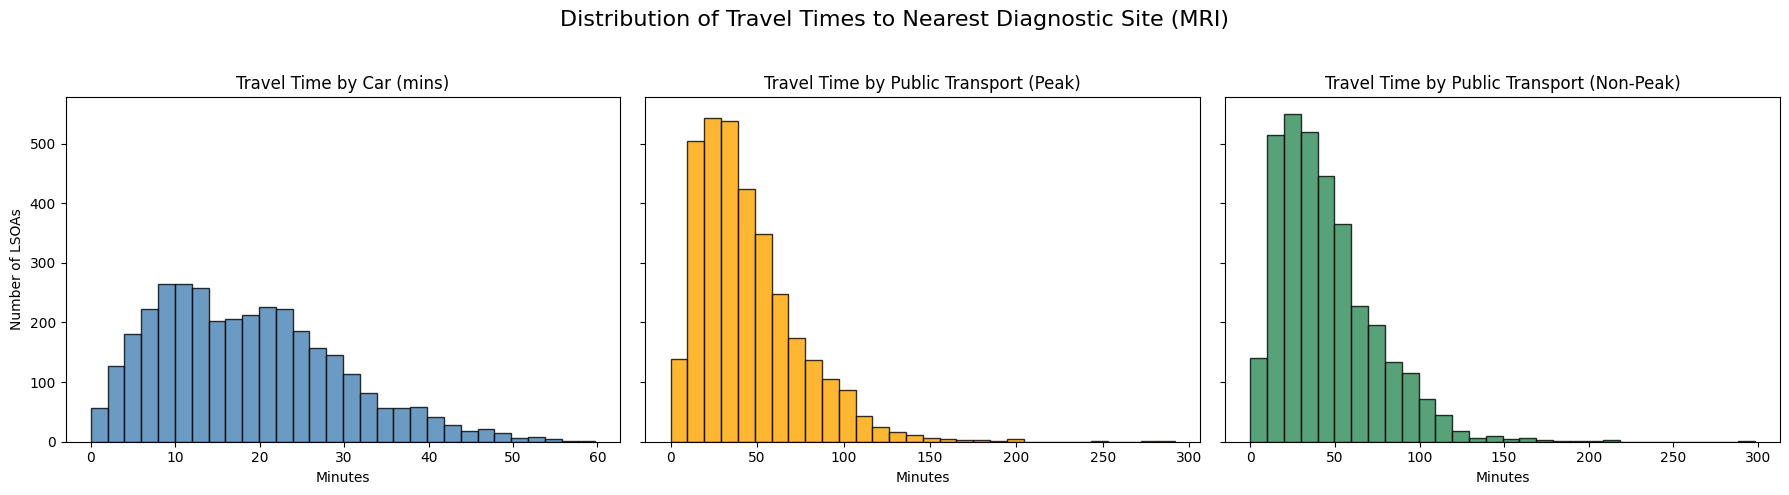


--- Summary Statistics of Travel Times (in minutes) ---
       travel_to_nearest_mins  travel_pt_peak_mins  travel_pt_nonpeak_mins
count                  3444.0               3365.0                  3379.0
mean                     18.6                 44.9                    45.1
std                      10.8                 29.9                    29.4
min                       0.0                  0.0                     0.0
25%                      10.0                 22.9                    23.2
50%                      17.3                 38.1                    39.1
75%                      25.2                 59.4                    59.6
max                      59.7                291.7                   298.3


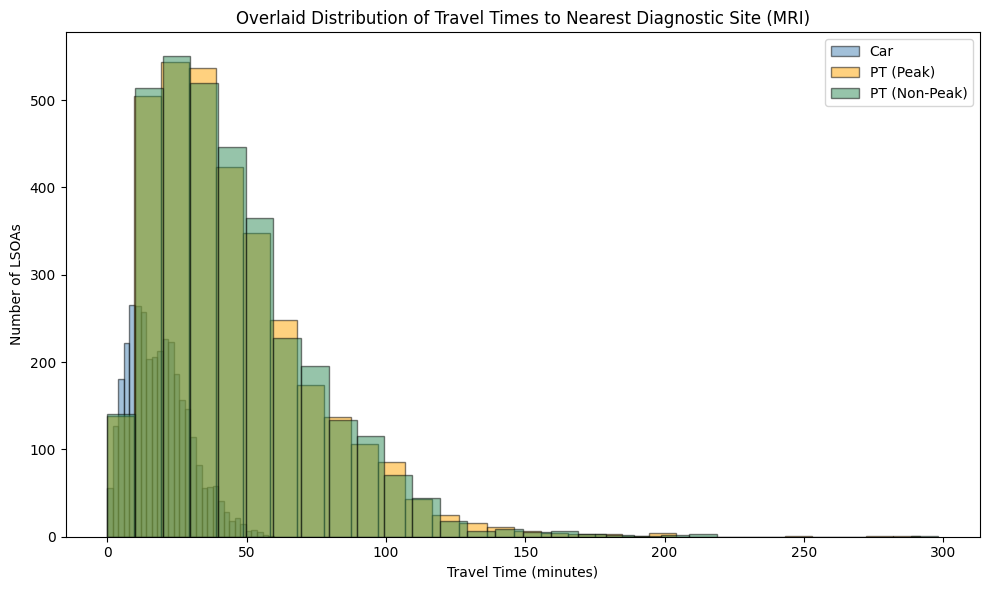

In [8]:
# ------------------------------------------------------------------
# Step 4 – Add PT Travel Times and Plot All Travel Time Histograms (MRI)
# ------------------------------------------------------------------

# Merge PT travel times into gdf_mri
pt_travel_times = travel_df[[
    "origin_lsoa", "dest_lsoa",
    "travel_time_pt_peak", "travel_time_pt_nonpeak"
]].copy()

# Only keep rows where destination is the nearest facility
nearest_merge = gdf_mri[["lsoa21cd", "nearest_site"]].merge(
    facilities_df[["Name", "lsoa21cd"]],
    left_on="nearest_site",
    right_on="Name",
    how="left",
    suffixes=("", "_site")
)

# Attach PT times from travel matrix
pt_merged = pt_travel_times.merge(
    nearest_merge,
    left_on=["origin_lsoa", "dest_lsoa"],
    right_on=["lsoa21cd", "lsoa21cd_site"],
    how="inner"
)

# Add to gdf_mri
gdf_mri = gdf_mri.merge(
    pt_merged[["origin_lsoa", "travel_time_pt_peak", "travel_time_pt_nonpeak"]],
    left_on="lsoa21cd",
    right_on="origin_lsoa",
    how="left"
).drop(columns="origin_lsoa")

# Rename for plotting consistency
gdf_mri = gdf_mri.rename(columns={
    "travel_time_pt_peak": "travel_pt_peak_mins",
    "travel_time_pt_nonpeak": "travel_pt_nonpeak_mins"
})

# ------------------------------------------------------------------
# Travel Time Histograms (Car, PT Peak, PT Non-Peak)
# ------------------------------------------------------------------

# Set style
plt.style.use("seaborn-v0_8-muted")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Define histogram settings
bins = 30
alpha = 0.8

# 1. Car travel time
axes[0].hist(
    gdf_mri["travel_to_nearest_mins"].dropna(),
    bins=bins,
    color="steelblue",
    alpha=alpha,
    edgecolor="black"
)
axes[0].set_title("Travel Time by Car (mins)")
axes[0].set_xlabel("Minutes")
axes[0].set_ylabel("Number of LSOAs")

# 2. Public transport (peak)
axes[1].hist(
    gdf_mri["travel_pt_peak_mins"].dropna(),
    bins=bins,
    color="orange",
    alpha=alpha,
    edgecolor="black"
)
axes[1].set_title("Travel Time by Public Transport (Peak)")
axes[1].set_xlabel("Minutes")

# 3. Public transport (non-peak)
axes[2].hist(
    gdf_mri["travel_pt_nonpeak_mins"].dropna(),
    bins=bins,
    color="seagreen",
    alpha=alpha,
    edgecolor="black"
)
axes[2].set_title("Travel Time by Public Transport (Non-Peak)")
axes[2].set_xlabel("Minutes")

# Final formatting
plt.suptitle("Distribution of Travel Times to Nearest Diagnostic Site (MRI)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ------------------------------------------------------------------
# Summary Statistics (printed after the plots)
# ------------------------------------------------------------------
print("\n--- Summary Statistics of Travel Times (in minutes) ---")
print(
    gdf_mri[[
        "travel_to_nearest_mins",
        "travel_pt_peak_mins",
        "travel_pt_nonpeak_mins"
    ]]
    .describe()
    .round(1)
)

# ------------------------------------------------------------------
# Combined Overlaid Histogram of Travel Times
# ------------------------------------------------------------------

plt.figure(figsize=(10, 6))
bins = 30
alpha = 0.5

plt.hist(
    gdf_mri["travel_to_nearest_mins"].dropna(),
    bins=bins,
    color="steelblue",
    alpha=alpha,
    edgecolor="black",
    label="Car"
)

plt.hist(
    gdf_mri["travel_pt_peak_mins"].dropna(),
    bins=bins,
    color="orange",
    alpha=alpha,
    edgecolor="black",
    label="PT (Peak)"
)

plt.hist(
    gdf_mri["travel_pt_nonpeak_mins"].dropna(),
    bins=bins,
    color="seagreen",
    alpha=alpha,
    edgecolor="black",
    label="PT (Non-Peak)"
)

plt.title("Overlaid Distribution of Travel Times to Nearest Diagnostic Site (MRI)")
plt.xlabel("Travel Time (minutes)")
plt.ylabel("Number of LSOAs")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


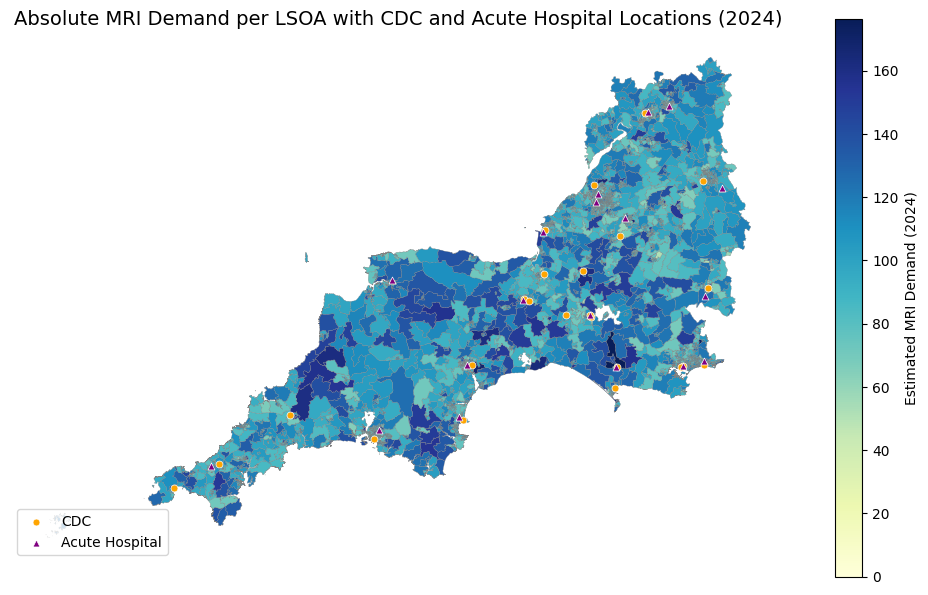

In [9]:
# ------------------------------------------------------------------
# Step 4 – Overlay MRI Demand Choropleth with Facility Locations
# ------------------------------------------------------------------

# 4.1 – Rebuild Base MRI Demand GeoDataFrame (if needed)
gdf_geom = gpd.read_file(gpkg_path)[["lsoa21cd", "geometry"]]
gdf_mri = gdf_geom.merge(
    mri_demand_df[["lsoa21cd", "mri_total_demand"]],
    on="lsoa21cd",
    how="left"
)

# 4.2 – Prepare Facility Point Locations (CDC + Acute)
facilities_df = pd.concat([
    cdc_df.assign(site_type="CDC"),
    acute_df.assign(site_type="Acute")
], ignore_index=True).dropna(subset=["lsoa21cd"]).drop_duplicates()

facilities_df["lsoa21cd"] = facilities_df["lsoa21cd"].astype(str)

# Merge facility records with LSOA geometries
facilities_gdf = facilities_df.merge(gdf_geom, on="lsoa21cd", how="left")
facilities_gdf = gpd.GeoDataFrame(facilities_gdf, geometry="geometry", crs=gdf_geom.crs)

# Use LSOA centroids for facility plotting
facilities_gdf["geometry"] = facilities_gdf["geometry"].centroid

# Split by facility type for plotting
cdc_gdf = facilities_gdf[facilities_gdf["site_type"] == "CDC"]
acute_gdf = facilities_gdf[facilities_gdf["site_type"] == "Acute"]

# 4.3 – Plot MRI Demand Choropleth + Facility Points
fig, ax = plt.subplots(figsize=(10, 6))

# Plot base MRI demand map
gdf_mri.plot(
    column="mri_total_demand",
    cmap="YlGnBu",
    linewidth=0.2,
    edgecolor="grey",
    legend=True,
    legend_kwds={'label': "Estimated MRI Demand (2024)"},
    ax=ax
)

# Overlay CDCs (orange)
cdc_gdf.plot(
    ax=ax,
    color="orange",
    markersize=25,
    label="CDC",
    marker="o",
    edgecolor="white",
    linewidth=0.5
)

# Overlay Acute Hospitals (purple)
acute_gdf.plot(
    ax=ax,
    color="purple",
    markersize=25,
    label="Acute Hospital",
    marker="^",
    edgecolor="white",
    linewidth=0.5
)

# Final formatting
ax.set_title("Absolute MRI Demand per LSOA with CDC and Acute Hospital Locations (2024)", fontsize=14)
ax.axis("off")
ax.legend(loc="lower left", frameon=True)

plt.tight_layout()
plt.savefig("mri_demand_with_facilities_overlay_2024.png", dpi=300, bbox_inches="tight")
plt.show()


/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_99413/4017224094.py:114: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="lower left", frameon=True)


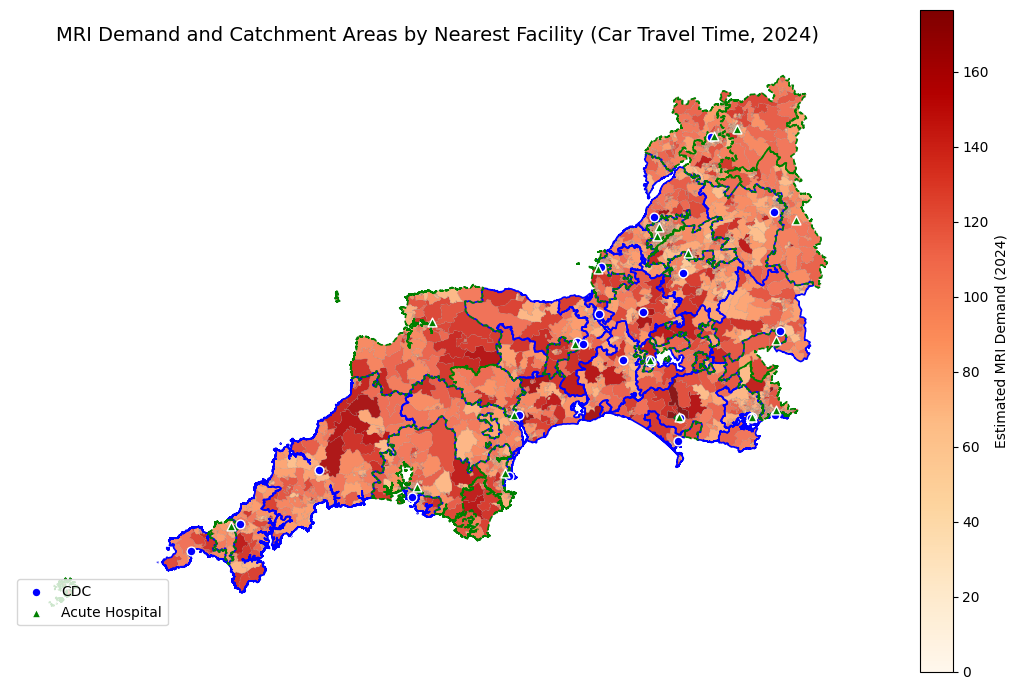

In [10]:
# ------------------------------------------------------------------
# Step 5 – Visualise MRI Catchment Areas by Nearest Facility (Car Travel Time)
# ------------------------------------------------------------------

# 5.1 – Load Base Geometry and MRI Demand
gdf_geom = gpd.read_file(gpkg_path)[["lsoa21cd", "geometry"]]
gdf_mri = gdf_geom.merge(
    mri_demand_df[["lsoa21cd", "mri_total_demand"]],
    on="lsoa21cd",
    how="left"
)

# 5.2 – Merge Nearest Site Assignments (from Step 3)
nearest_sites["lsoa21cd"] = nearest_sites["lsoa21cd"].astype(str)
gdf_mri["lsoa21cd"] = gdf_mri["lsoa21cd"].astype(str)

gdf_mri = gdf_mri.merge(
    nearest_sites[[
        "lsoa21cd",
        "nearest_site",
        "nearest_type",
        "travel_to_nearest_mins"
    ]],
    on="lsoa21cd",
    how="left"
)

# 5.3 – Prepare Facility Points (Centroids)
facilities_df = pd.concat([
    cdc_df.assign(site_type="CDC"),
    acute_df.assign(site_type="Acute")
], ignore_index=True).dropna(subset=["lsoa21cd"]).drop_duplicates()

facilities_df["lsoa21cd"] = facilities_df["lsoa21cd"].astype(str)

# Attach geometries
facilities_gdf = facilities_df.merge(gdf_geom, on="lsoa21cd", how="left")
facilities_gdf = gpd.GeoDataFrame(facilities_gdf, geometry="geometry", crs=gdf_geom.crs)

# Use centroids for visual clarity
facilities_gdf["geometry"] = facilities_gdf.geometry.centroid

# Split by facility type
cdc_gdf = facilities_gdf[facilities_gdf["site_type"] == "CDC"]
acute_gdf = facilities_gdf[facilities_gdf["site_type"] == "Acute"]

# 5.4 – Dissolve LSOAs into Catchment Polygons by Nearest Facility
catchment_gdf = gdf_mri.dissolve(by="nearest_site", as_index=False)

# Map site_type from facilities to catchments
site_type_map = facilities_df.set_index("Name")["site_type"].to_dict()
catchment_gdf["site_type"] = catchment_gdf["nearest_site"].map(site_type_map)

# Split catchments by facility type
catchment_cdc = catchment_gdf[catchment_gdf["site_type"] == "CDC"]
catchment_acute = catchment_gdf[catchment_gdf["site_type"] == "Acute"]

# 5.5 – Plot: Choropleth + Catchments + Facilities
fig, ax = plt.subplots(figsize=(11, 7))

# Base: MRI demand
gdf_mri.plot(
    column="mri_total_demand",
    cmap="OrRd",
    linewidth=0.1,
    edgecolor="grey",
    legend=True,
    legend_kwds={'label': "Estimated MRI Demand (2024)"},
    ax=ax,
    alpha=0.9
)

# Catchment outlines
catchment_cdc.plot(
    ax=ax,
    facecolor="none",
    edgecolor="blue",
    linewidth=1.2,
    linestyle="-",
    label="CDC Catchment (Car)"
)

catchment_acute.plot(
    ax=ax,
    facecolor="none",
    edgecolor="green",
    linewidth=1.2,
    linestyle="--",
    label="Acute Catchment (Car)"
)

# Facility markers
cdc_gdf.plot(
    ax=ax,
    color="blue",
    markersize=40,
    marker="o",
    edgecolor="white",
    label="CDC"
)

acute_gdf.plot(
    ax=ax,
    color="green",
    markersize=40,
    marker="^",
    edgecolor="white",
    label="Acute Hospital"
)

# Final formatting
ax.set_title("MRI Demand and Catchment Areas by Nearest Facility (Car Travel Time, 2024)", fontsize=14)
ax.axis("off")
ax.legend(loc="lower left", frameon=True)

plt.tight_layout()
plt.savefig("mri_demand_with_car_catchments_2024.png", dpi=300, bbox_inches="tight")
plt.show()


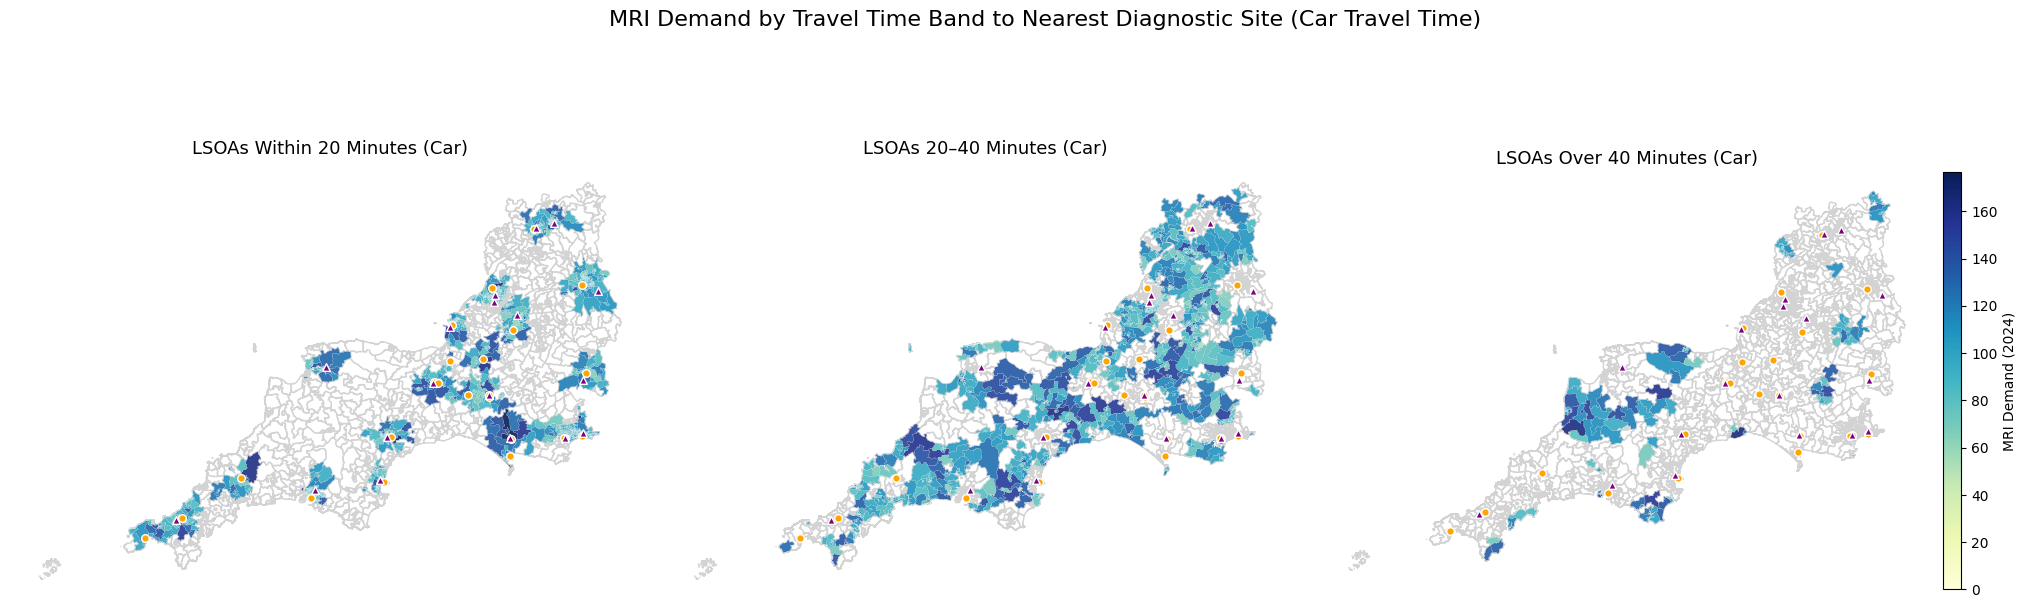

In [11]:
# ------------------------------------------------------------------
# Step 6 – MRI Demand by Travel Time Band to Nearest Facility (Car Travel Time)
# ------------------------------------------------------------------

# Define travel time bands
lt_20 = gdf_mri[gdf_mri["travel_to_nearest_mins"] < 20].copy()
btw_20_40 = gdf_mri[
    (gdf_mri["travel_to_nearest_mins"] >= 20) & 
    (gdf_mri["travel_to_nearest_mins"] <= 40)
].copy()
gt_40 = gdf_mri[gdf_mri["travel_to_nearest_mins"] > 40].copy()

# Use consistent colour scale across all maps
vmin = gdf_mri["mri_total_demand"].min()
vmax = gdf_mri["mri_total_demand"].max()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

# Shared plotting style
plot_kwargs = dict(
    column="mri_total_demand",
    cmap="YlGnBu",
    linewidth=0.1,
    edgecolor="white",
    vmin=vmin,
    vmax=vmax,
    alpha=0.9,
    legend=False
)

# Plot 1 – <20 minutes
gdf_mri.assign(dummy=False).plot(ax=axes[0], color="white", edgecolor="lightgrey")
lt_20.plot(ax=axes[0], **plot_kwargs)
cdc_gdf.plot(ax=axes[0], color="orange", markersize=30, marker="o", edgecolor="white", label="CDC")
acute_gdf.plot(ax=axes[0], color="purple", markersize=30, marker="^", edgecolor="white", label="Acute")
axes[0].set_title("LSOAs Within 20 Minutes (Car)", fontsize=13)
axes[0].axis("off")

# Plot 2 – 20 to 40 minutes
gdf_mri.assign(dummy=False).plot(ax=axes[1], color="white", edgecolor="lightgrey")
btw_20_40.plot(ax=axes[1], **plot_kwargs)
cdc_gdf.plot(ax=axes[1], color="orange", markersize=30, marker="o", edgecolor="white")
acute_gdf.plot(ax=axes[1], color="purple", markersize=30, marker="^", edgecolor="white")
axes[1].set_title("LSOAs 20–40 Minutes (Car)", fontsize=13)
axes[1].axis("off")

# Plot 3 – Over 40 minutes
gdf_mri.assign(dummy=False).plot(ax=axes[2], color="white", edgecolor="lightgrey")
gt_40.plot(ax=axes[2], **plot_kwargs)
cdc_gdf.plot(ax=axes[2], color="orange", markersize=30, marker="o", edgecolor="white")
acute_gdf.plot(ax=axes[2], color="purple", markersize=30, marker="^", edgecolor="white")
axes[2].set_title("LSOAs Over 40 Minutes (Car)", fontsize=13)
axes[2].axis("off")

# Shared colourbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="3%", pad=0.1)

gdf_mri.plot(
    column="mri_total_demand",
    cmap="YlGnBu",
    ax=axes[2],
    alpha=0,  # dummy for colorbar only
    legend=True,
    cax=cax,
    vmin=vmin,
    vmax=vmax,
    legend_kwds={"label": "MRI Demand (2024)"}
)

# Final layout
plt.suptitle("MRI Demand by Travel Time Band to Nearest Diagnostic Site (Car Travel Time)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.97, 0.95])
plt.savefig("mri_demand_travel_time_band_maps_2024.png", dpi=300, bbox_inches="tight")
plt.show()


In [12]:
# ------------------------------------------------------------------
# Patch: Add PT Peak and Non-Peak Travel Times to gdf_mri
# ------------------------------------------------------------------

# Prepare PT travel time merge table
pt_times = travel_df[[
    "origin_lsoa", "dest_lsoa", "travel_time_pt_peak", "travel_time_pt_nonpeak"
]]

# Map LSOA→nearest site from earlier result
nearest_merge = gdf_mri[["lsoa21cd", "nearest_site"]].merge(
    facilities_df[["Name", "lsoa21cd"]],
    left_on="nearest_site",
    right_on="Name",
    how="left",
    suffixes=("", "_site")
)

# Join PT times: origin = LSOA, destination = nearest site LSOA
pt_merged = pt_times.merge(
    nearest_merge,
    left_on=["origin_lsoa", "dest_lsoa"],
    right_on=["lsoa21cd", "lsoa21cd_site"],
    how="inner"
)

# Merge PT times back into gdf_mri
gdf_mri = gdf_mri.merge(
    pt_merged[["origin_lsoa", "travel_time_pt_peak", "travel_time_pt_nonpeak"]],
    left_on="lsoa21cd",
    right_on="origin_lsoa",
    how="left"
).drop(columns="origin_lsoa")

# Rename for consistency
gdf_mri = gdf_mri.rename(columns={
    "travel_time_pt_peak": "travel_pt_peak_mins",
    "travel_time_pt_nonpeak": "travel_pt_nonpeak_mins"
})


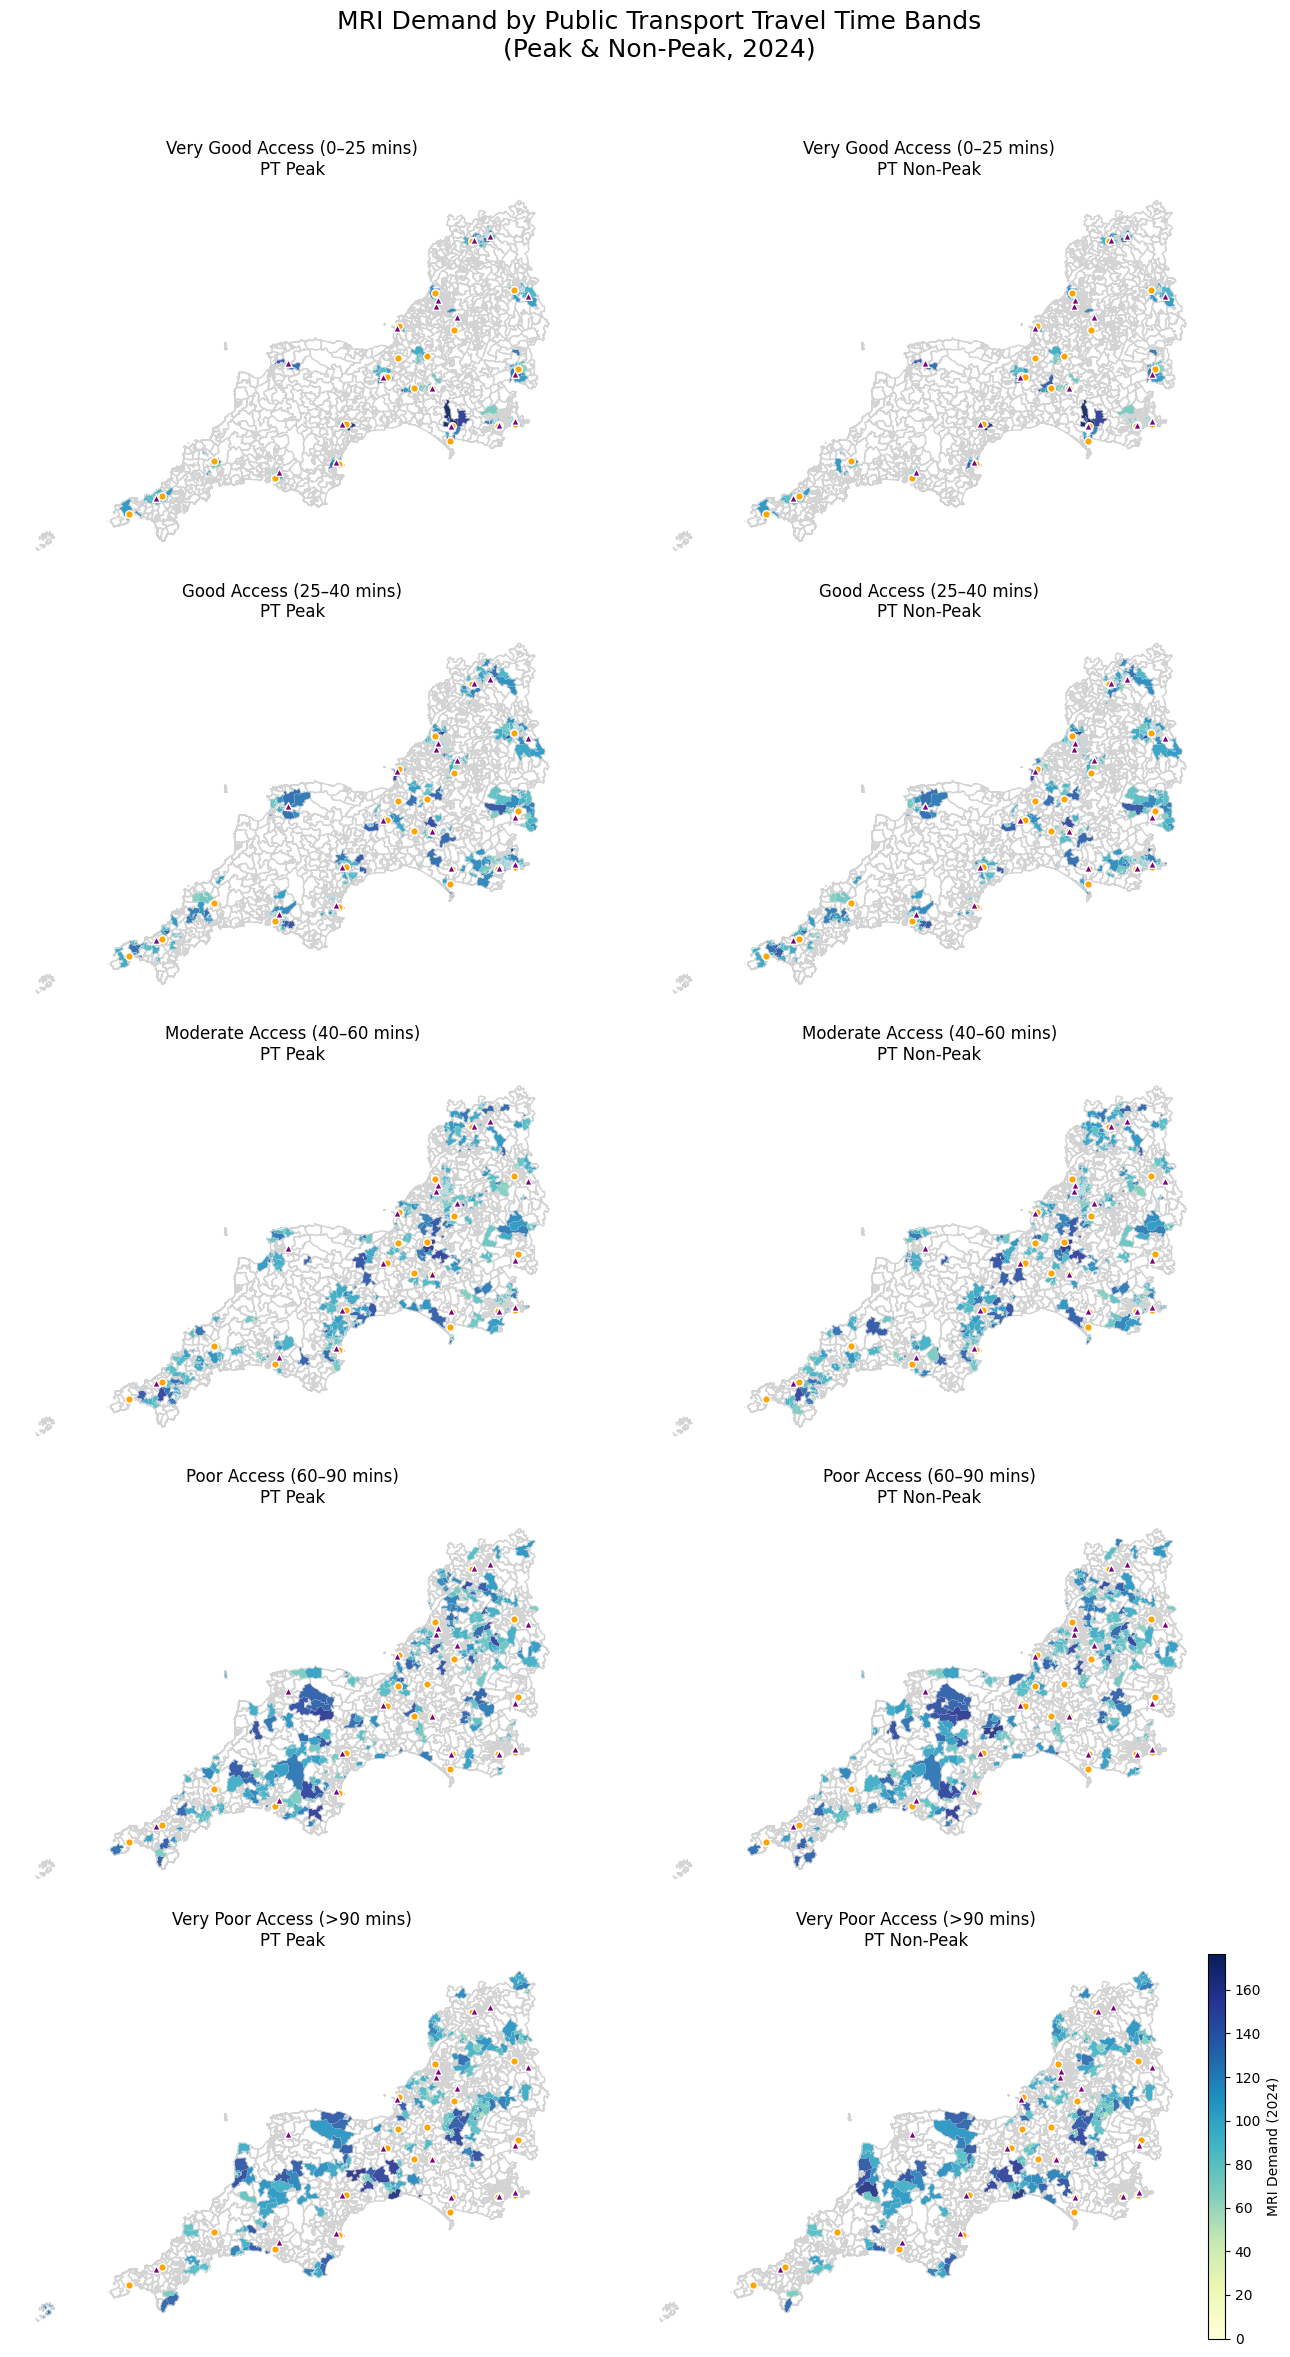

In [13]:
# ------------------------------------------------------------------
# Step 7 – MRI Demand by Public Transport Access Band (Peak & Non-Peak)
# ------------------------------------------------------------------

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# ----------------------------------------------
# Assign PT Travel Time Bands
# ----------------------------------------------
def assign_band(val):
    if pd.isna(val):
        return None
    if val <= 25:
        return "Very Good"
    elif val <= 40:
        return "Good"
    elif val <= 60:
        return "Moderate"
    elif val <= 90:
        return "Poor"
    else:
        return "Very Poor"

gdf_mri["pt_peak_band"] = gdf_mri["travel_pt_peak_mins"].apply(assign_band)
gdf_mri["pt_nonpeak_band"] = gdf_mri["travel_pt_nonpeak_mins"].apply(assign_band)

# ----------------------------------------------
# MRI demand scale for all plots
# ----------------------------------------------
vmin = gdf_mri["mri_total_demand"].min()
vmax = gdf_mri["mri_total_demand"].max()

# Band order and labels
band_order = ["Very Good", "Good", "Moderate", "Poor", "Very Poor"]
band_ranges = {
    "Very Good": "0–25 mins",
    "Good": "25–40 mins",
    "Moderate": "40–60 mins",
    "Poor": "60–90 mins",
    "Very Poor": ">90 mins"
}

# Shared style
plot_kwargs = dict(
    column="mri_total_demand",
    cmap="YlGnBu",
    linewidth=0.1,
    edgecolor="white",
    vmin=vmin,
    vmax=vmax,
    alpha=0.9,
    legend=False
)

# ----------------------------------------------
# Create 5×2 Grid of Maps (PT Peak vs Non-Peak)
# ----------------------------------------------
fig, axes = plt.subplots(5, 2, figsize=(14, 24))

for row, band in enumerate(band_order):
    for col, mode in enumerate(["pt_peak_band", "pt_nonpeak_band"]):
        ax = axes[row, col]

        # Background
        gdf_mri.assign(dummy=0).plot(ax=ax, color="white", edgecolor="lightgrey")

        # Overlay selected band
        gdf_mri[gdf_mri[mode] == band].plot(ax=ax, **plot_kwargs)

        # Overlay facility markers (orange CDC, purple Acute)
        cdc_gdf.plot(ax=ax, color="orange", markersize=30, marker="o", edgecolor="white")
        acute_gdf.plot(ax=ax, color="purple", markersize=30, marker="^", edgecolor="white")

        # Set title
        mode_label = "PT Peak" if col == 0 else "PT Non-Peak"
        band_label = f"{band} Access ({band_ranges[band]})"
        ax.set_title(f"{band_label}\n{mode_label}", fontsize=12)
        ax.axis("off")

# ----------------------------------------------
# Shared Colourbar
# ----------------------------------------------
divider = make_axes_locatable(axes[4, 1])
cax = divider.append_axes("right", size="3%", pad=0.1)

gdf_mri.plot(
    column="mri_total_demand",
    cmap="YlGnBu",
    ax=axes[4, 1],
    alpha=0,  # invisible plot for colorbar only
    legend=True,
    cax=cax,
    vmin=vmin,
    vmax=vmax,
    legend_kwds={"label": "MRI Demand (2024)"}
)

# ----------------------------------------------
# Final Layout
# ----------------------------------------------
plt.suptitle("MRI Demand by Public Transport Travel Time Bands\n(Peak & Non-Peak, 2024)", fontsize=18)
plt.tight_layout(rect=[0, 0, 0.97, 0.96])
plt.savefig("mri_demand_pt_peak_nonpeak_bands_5x2_2024.png", dpi=300, bbox_inches="tight")
plt.show()


In [14]:
# ------------------------------------------------------------------
# Step – Load full base geometry + demographics
# ------------------------------------------------------------------
gdf_base = gpd.read_file(gpkg_path)  # Do NOT subset columns now

# ------------------------------------------------------------------
# Step – Merge in MRI total + age-segmented demand
# ------------------------------------------------------------------
age_cols = [
    "mri_age_0_4", "mri_age_5_9", "mri_age_10_14", "mri_age_15_19", "mri_age_20_24",
    "mri_age_25_29", "mri_age_30_34", "mri_age_35_39", "mri_age_40_44", "mri_age_45_49",
    "mri_age_50_54", "mri_age_55_59", "mri_age_60_64", "mri_age_65_69", "mri_age_70_74",
    "mri_age_75_79", "mri_age_80_84", "mri_age_85_plus"
]
demand_columns = ["lsoa21cd", "mri_total_demand"] + age_cols

# Merge by LSOA code
gdf_enriched = gdf_base.merge(
    mri_demand_df[demand_columns],
    on="lsoa21cd",
    how="left"
)

# Confirm CRS and cast as GeoDataFrame
gdf_enriched = gpd.GeoDataFrame(gdf_enriched, geometry="geometry", crs=gdf_base.crs)

# ------------------------------------------------------------------
# Step – Save enriched GPKG to processed folder
# ------------------------------------------------------------------
output_gpkg_path = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/LSOA_MRI_Demand_with_Demographics_2024_v1.gpkg"

gdf_enriched.to_file(output_gpkg_path, layer="mri_demand", driver="GPKG")

print(f"\nSaved enriched GPKG with demographics + MRI demand to:\n{output_gpkg_path}")



Saved enriched GPKG with demographics + MRI demand to:
/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/LSOA_MRI_Demand_with_Demographics_2024_v1.gpkg


In [15]:
# ------------------------------------------------------------------
# Preview Enriched GPKG with Demographics + MRI Demand
# ------------------------------------------------------------------

import geopandas as gpd

# Define updated path to enriched processed GPKG
gpkg_check_path = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/LSOA_MRI_Demand_with_Demographics_2024_v1.gpkg"

# Load GeoDataFrame from specified layer
gdf_check = gpd.read_file(gpkg_check_path, layer="mri_demand")

# Display preview
print("\nPreview of enriched GPKG with Demographics + MRI Demand:\n")
display(gdf_check.head())

# List all column names
print("\nColumn names in GPKG:")
print(gdf_check.columns.tolist())



Preview of enriched GPKG with Demographics + MRI Demand:



,ICB23NM,ladnm,ladcd,msoa21nm,msoa21cd,lsoa21nmw,lsoa21cd,total_population,age_0_4,age_5_9,...,mri_age_45_49,mri_age_50_54,mri_age_55_59,mri_age_60_64,mri_age_65_69,mri_age_70_74,mri_age_75_79,mri_age_80_84,mri_age_85_plus,geometry
0,NHS Dorset Integrated Care Board,Dorset,E06000059,Dorset 042,E02004268,None,E01020484,1444.99,43.76,70.21,...,5.002384,7.013377,8.454571,10.699525,9.221666,8.839622,8.570267,5.471246,2.735108,"MULTIPOLYGON (((401918.077 78945.278, 401919.4..."
1,NHS Dorset Integrated Care Board,Dorset,E06000059,Dorset 042,E02004268,None,E01020481,1347.30,39.69,32.56,...,3.394224,4.457436,8.756494,13.633457,11.616180,12.549362,11.282391,5.295202,4.397253,"MULTIPOLYGON (((403211.07 78762.983, 403211.07..."
2,NHS Dorset Integrated Care Board,Dorset,E06000059,Dorset 042,E02004268,None,E01020482,1585.42,70.21,77.34,...,5.240564,5.964720,9.587337,12.770236,9.044779,10.260539,10.089440,4.323923,2.788862,"MULTIPOLYGON (((403126.904 78828.641, 403127.4..."
3,NHS Dorset Integrated Care Board,Dorset,E06000059,Dorset 042,E02004268,None,E01020479,1150.91,33.58,32.56,...,2.977554,3.277375,5.737269,6.644593,9.221666,8.287388,12.801564,8.207302,8.204797,"MULTIPOLYGON (((403027.597 79673.678, 403027.8..."
4,NHS Dorset Integrated Care Board,Dorset,E06000059,Dorset 042,E02004268,None,E01020478,1129.54,37.65,44.77,...,3.275426,5.309631,7.775060,7.852084,7.803082,7.340369,8.895424,4.235468,2.949595,"MULTIPOLYGON (((402493.1 79584.202, 402511.903..."



Column names in GPKG:
['ICB23NM', 'ladnm', 'ladcd', 'msoa21nm', 'msoa21cd', 'lsoa21nmw', 'lsoa21cd', 'total_population', 'age_0_4', 'age_5_9', 'age_10_14', 'age_15_19', 'age_20_24', 'age_25_29', 'age_30_34', 'age_35_39', 'age_40_44', 'age_45_49', 'age_50_54', 'age_55_59', 'age_60_64', 'age_65_69', 'age_70_74', 'age_75_79', 'age_80_84', 'age_85_plus', 'lat', 'long', 'bng_e', 'bng_n', 'lsoa21nm', 'mri_total_demand', 'mri_age_0_4', 'mri_age_5_9', 'mri_age_10_14', 'mri_age_15_19', 'mri_age_20_24', 'mri_age_25_29', 'mri_age_30_34', 'mri_age_35_39', 'mri_age_40_44', 'mri_age_45_49', 'mri_age_50_54', 'mri_age_55_59', 'mri_age_60_64', 'mri_age_65_69', 'mri_age_70_74', 'mri_age_75_79', 'mri_age_80_84', 'mri_age_85_plus', 'geometry']
